In [2]:
import torch 
import torch.nn as nn 

import numpy as np 
from tqdm import tqdm
from torchvision.utils import save_image, make_grid 

In [3]:
# model hyperparameters 

dataset_path = "~/datasets"

cuda = True
Device = torch.device("cuda" if cuda else "cpu")

batch_size = 100 
x_dim = 784 
hidden_dim = 400 
latent_dim = 200 

lr = 1e-3 
epochs = 30

## Step 1. Load (or download) Dataset

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

## step 2. Define our model: Variational AutoEncoder (VAE)

In [7]:
""" 
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True


    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var
    

class Decoder(nn.Module):

    def __init__(self, latent_dim, hidden_dim, output_dim):

        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    


class Model(nn.Module):

    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparametrization(self, mean, var):
        epsilon = torch.rand_like(var).to(Device)
        z = mean + var*epsilon
        return z 
    

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparametrization(mean, torch.exp(0.5 * log_var))  # takes exponential function (log var --> var)
        x_hat = self.Decoder(z)


        return x_hat, mean, log_var

In [8]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(Device)


## setp 3. Define Loss function and optimizer

In [9]:
from torch.optim import Adam 
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD 


optimizer = Adam(model.parameters(), lr=lr)

## step 4. Train variational AutoEncoder (VAE)

In [11]:
print("Start training VAE...")
model.train()


for epoch in range(epochs):

    overall_loss = 0 
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(Device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()


    print("\tEpoch", epoch + 1,
          "complete!", "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    
print("Finsh!!")


Start training VAE...
	Epoch 1 complete! 	Average Loss:  80.42917306839524
	Epoch 2 complete! 	Average Loss:  80.1611106645842
	Epoch 3 complete! 	Average Loss:  79.807837753678
	Epoch 4 complete! 	Average Loss:  79.53088505256156
	Epoch 5 complete! 	Average Loss:  79.24909598680092
	Epoch 6 complete! 	Average Loss:  79.06465389092497
	Epoch 7 complete! 	Average Loss:  78.85228880001826
	Epoch 8 complete! 	Average Loss:  78.68576947907971
	Epoch 9 complete! 	Average Loss:  78.50170450914284
	Epoch 10 complete! 	Average Loss:  78.37751248011008
	Epoch 11 complete! 	Average Loss:  78.2207049183535
	Epoch 12 complete! 	Average Loss:  78.09610519485601
	Epoch 13 complete! 	Average Loss:  77.99492220921589
	Epoch 14 complete! 	Average Loss:  77.84437248930509
	Epoch 15 complete! 	Average Loss:  77.74573649767842
	Epoch 16 complete! 	Average Loss:  77.67127651717706
	Epoch 17 complete! 	Average Loss:  77.51593656256522
	Epoch 18 complete! 	Average Loss:  77.47554570116861
	Epoch 19 complete!

## Step 5. Generate images from test dataset

In [19]:
import matplotlib.pyplot as plt 



model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        # print("x", x)
        x = x.to(Device)
        # print("device", x)

        x_hat, _, _ = model(x)
        print("x_hat", x_hat)
        print("_", _)
        




        break

  0%|          | 0/100 [00:00<?, ?it/s]

x_hat tensor([[3.8741e-13, 4.7189e-13, 2.6326e-13,  ..., 8.8260e-13, 6.0173e-13,
         7.0596e-13],
        [1.2646e-16, 4.1777e-16, 8.4559e-17,  ..., 2.3162e-15, 4.4507e-16,
         9.7950e-16],
        [7.2675e-12, 9.4287e-12, 6.4877e-12,  ..., 1.6497e-11, 1.0322e-11,
         9.9808e-12],
        ...,
        [4.5247e-11, 4.5422e-11, 5.4207e-11,  ..., 6.0906e-11, 5.8659e-11,
         7.1236e-11],
        [1.2393e-15, 1.3496e-15, 2.6531e-15,  ..., 1.4226e-15, 6.9252e-16,
         1.3791e-15],
        [1.6044e-15, 2.8981e-15, 3.0743e-15,  ..., 6.2173e-15, 4.4390e-15,
         2.5859e-15]], device='cuda:0')
_ tensor([[-0.0529, -0.0343,  0.1019,  ..., -0.3937,  0.0391,  0.0554],
        [-0.0195,  0.0129, -1.0978,  ..., -0.5395, -0.0174, -0.1312],
        [-0.0516, -0.0732, -0.0929,  ..., -0.0468, -0.1291, -0.0817],
        ...,
        [-0.0587, -0.1385, -1.0246,  ..., -0.1741, -0.0191, -0.0176],
        [ 0.0221, -0.0308, -1.0066,  ..., -0.3743, -0.1332,  0.1801],
        [ 0.0087

  0%|          | 0/100 [00:02<?, ?it/s]


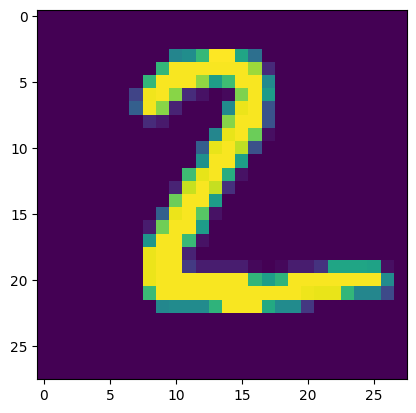

In [22]:
def show_image(x, idx): 
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

show_image(x, idx=1)

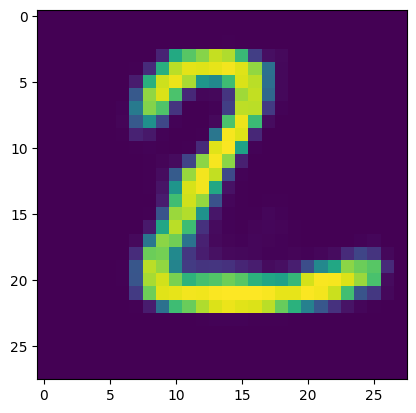

In [23]:
show_image(x_hat, idx=1)

## step 6. Generate image from noise vector

In [24]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(Device)
    generated_images = decoder(noise)

In [25]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

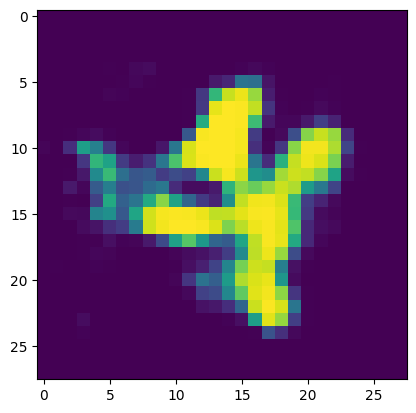

In [26]:
show_image(generated_images, idx=12)

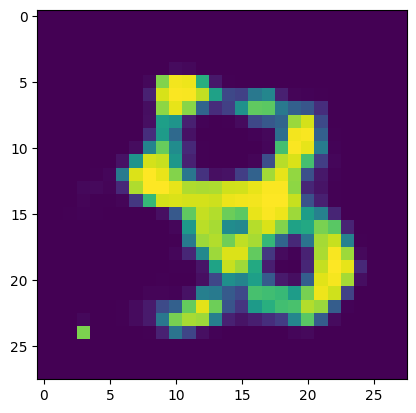

In [27]:
show_image(generated_images, idx=2)
